# M02. Predict PAs
- This predicts the outcome of plate appearances
- Type: Model
- Run Frequency: Irregular
- Sources:
    - MLB API
    - Steamer
- Dates:
    - Created: 4/19/2024
    - Updated: 4/21/2024

### Imports

In [1]:
%run "U1. Imports.ipynb"
%run "U2. Utilities.ipynb"
%run "U3. Classes.ipynb"
%run "U4. Datasets.ipynb"

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, classification_report, f1_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from tensorflow import keras
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC

import matplotlib.pyplot as plt

In [3]:
# Set option to display numbers without scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

### Dataset

In [4]:
# Read in park factors
multiplier_df = pd.read_csv(os.path.join(baseball_path, "Multiplier Dataset.csv"))

In [5]:
%%time
complete_dataset = create_pa_inputs(multiplier_df, 2015, 2024, short=50, long=300, adjust=True)

CPU times: total: 6min 3s
Wall time: 6min 26s


##### Standardize Inputs

In [6]:
# Standardize
complete_dataset[batter_inputs] = batter_stats_scaler.transform(complete_dataset[batter_inputs])
complete_dataset[pitcher_inputs] = pitcher_stats_scaler.transform(complete_dataset[pitcher_inputs])

### Steamer

In [7]:
# Read in Steamer hitters 
steamer_hitters_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_hitters_weekly_log.csv"), encoding='iso-8859-1')
# Clean
steamer_hitters_df2 = clean_steamer_hitters(steamer_hitters_df)
steamer_hitters_df2.dropna(subset=batter_stats_fg, inplace=True)

In [8]:
# Read in Steamer hitters 
steamer_pitchers_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_pitchers_weekly_log.csv"), encoding='iso-8859-1')
# Clean
steamer_pitchers_df2 = clean_steamer_pitchers(steamer_pitchers_df)
steamer_pitchers_df2.dropna(subset=pitcher_stats_fg2, inplace=True)

In [9]:
# Standardize
steamer_hitters_df2[batter_stats_fg] = batter_stats_fg_scaler.transform(steamer_hitters_df2[batter_stats_fg])
steamer_pitchers_df2[pitcher_stats_fg] = pitcher_stats_fg_scaler.transform(steamer_pitchers_df2[pitcher_stats_fg])

### Merge

In [10]:
# Find the dates of Steamer projections
# We'll take the most recent and merge in that projection for each player
batter_steamer_dates = list(steamer_hitters_df2['date'].unique())
pitcher_steamer_dates = list(steamer_pitchers_df2['date'].unique())

# Define a function to find the largest number in "steamer_dates" less than or equal to a given "date"
def find_steamer_date(date, steamer_dates):
    max_steamer_date = max(filter(lambda d: d <= date, steamer_dates), default=None)
    return max_steamer_date

# Apply the function to create the "steamer_date" column in your DataFrame
complete_dataset["batter_date"] = complete_dataset["date"].apply(lambda x: find_steamer_date(x, batter_steamer_dates))
complete_dataset["pitcher_date"] = complete_dataset["date"].apply(lambda x: find_steamer_date(x, pitcher_steamer_dates))

In [11]:
# Steamer stats we want to keep
batter_stats_fg_plus = ['mlbamid', 'steamerid', 'date'] + batter_stats_fg 
pitcher_stats_fg_plus = ['mlbamid', 'steamerid', 'date'] + pitcher_stats_fg 

# Merge
complete_merged_df = pd.merge(complete_dataset, steamer_hitters_df2[batter_stats_fg_plus], left_on=['batter', 'batter_date'], right_on=['mlbamid', 'date'], how='inner')
complete_merged_df = pd.merge(complete_merged_df, steamer_pitchers_df2[pitcher_stats_fg_plus], left_on=['pitcher', 'pitcher_date'], right_on=['mlbamid', 'date'], how='inner')

### Impute

For players with insufficient sample sizes, stats are imputed

##### Option 1: Steamer

In [12]:
# Add hands to use in imputation
batter_stats_fg_imp = batter_stats_fg + ['b_L', 'p_L']
pitcher_stats_fg_imp = pitcher_stats_fg + ['b_L', 'p_L']

### Batters
# Use Steamer stats to predict API/Statcast stats for those with limited samples
batter_predictions = batter_imputations_model.predict(complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_stats_fg_imp])

# Impute inputs with limited sample size with predicted values
complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_inputs] = batter_predictions

### Pitchers
# Use Steamer stats to predict API/Statcast stats for those with limited samples
pitcher_predictions = pitcher_imputations_model.predict(complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_stats_fg_imp])

# Impute inputs with limited sample size with predicted values
complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_inputs] = pitcher_predictions

##### Option 2: 0s

In [13]:
# # Testing instead of imputing, just weighting with 0s
# complete_merged_df[batter_inputs].fillna(0, inplace=True)
# complete_merged_df[pitcher_inputs].fillna(0, inplace=True)

# # Calculate the weighted average for each column in pitcher_stats
# # Could be simplified, but I wanted to show the steps
# # Weighted average of provided value and 0. PAs and 50-PAs are weights. 
# for col in batter_inputs:
#     complete_merged_df[col] = (complete_merged_df[col] * complete_merged_df['pa_b'] + 0 * (50-complete_merged_df['pa_b']))/50

# # Calculate the weighted average for each column in pitcher_stats
# for col in pitcher_inputs:
#     complete_merged_df[col] = (complete_merged_df[col] * complete_merged_df['pa_p'] + 0 * (50-complete_merged_df['pa_p']))/50

### Clean Data

Shift cumulative pitcher game stats

In [14]:
sum_list = [column for column in complete_merged_df.columns if "_sum" in column]

complete_merged_df.sort_values(['gamePk', 'atBatIndex'], ascending=True, inplace=True)

complete_merged_df[sum_list] = complete_merged_df.groupby(['gamePk', 'pitcher'])[sum_list].shift(1)
complete_merged_df[sum_list] = complete_merged_df[sum_list].fillna(0)

### Select Data

Drop early observations

In [15]:
complete_merged_df = complete_merged_df[complete_merged_df['game_date'] > '2015-07-01']

Drop atypical events

In [16]:
# Filter out events that didn't end with reaching base or an out
complete_merged_df = complete_merged_df.query('eventsModel != "Cut"')

Drop inactive parks

In [17]:
# Only keep active parks (move this up)
active_parks = list(team_map['VENUE_ID'].astype(int))
complete_merged_df = complete_merged_df[complete_merged_df['venue_id'].astype(int).isin(active_parks)]

Select side-specific multiplier

In [18]:
for event in events_list:
    # Assign multiplier for their 
    complete_merged_df[f'{event}_mult'] = np.where(complete_merged_df['batSide'] == "L", complete_merged_df[f'{event}_mult_l'], complete_merged_df[f'{event}_mult_r'])

In [19]:
multiplier_inputs = [f'{event}_mult' for event in events_list]

##### TESTING

Coors dummy

In [20]:
complete_merged_df['coors'] = (complete_merged_df['venue_id'] == "19").astype(int)

In [21]:
complete_merged_df['winning'] = (complete_merged_df['preBatterScore'] > complete_merged_df['prePitcherScore']).astype(int)
complete_merged_df['winning_big'] = (complete_merged_df['preBatterScore'] > complete_merged_df['prePitcherScore'] + 3).astype(int)

In [22]:
test_inputs = ['prePitcherScore', 'preBatterScore', 'coors', 'winning', 'winning_big', 'times_faced'] + sum_list

### Select Variables

In [23]:
pa_inputs2 = batter_inputs + pitcher_inputs + hand_inputs + game_state_inputs + imp_inputs + starter_inputs + multiplier_inputs + test_inputs
keep_list = pa_inputs2 + ['pa_b', 'pa_p', 'year', 'venue_id', 'is_out', 'eventsModel', 'batterName', 'pitcherName']

In [24]:
# Keep relevant variables
model_dataset = complete_merged_df[keep_list]
# Drop if missing information
model_dataset.dropna(subset=pa_inputs2, inplace=True)
model_dataset.reset_index(drop=True, inplace=True)

### Train/Test Split

In [25]:
np.random.seed(42)

# Create a column 'split' with random values to achieve a 2/3 to 1/3 split
model_dataset['split'] = np.random.choice([0, 0, 1], size=len(model_dataset))

# Split the DataFrame into training and testing sets based on the 'split' column
training_dataset = model_dataset[model_dataset['split'] == 0].drop('split', axis=1)
testing_dataset = model_dataset[model_dataset['split'] == 1].drop('split', axis=1)

In [26]:
# outs_training_dataset = training_dataset[training_dataset['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()
# safe_training_dataset = training_dataset[~training_dataset['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()

In [27]:
# outs_testing_dataset = testing_dataset[testing_dataset['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()
# safe_testing_dataset = testing_dataset[~testing_dataset['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()

In [28]:
del complete_merged_df, complete_dataset, model_dataset, steamer_hitters_df, steamer_hitters_df2, steamer_pitchers_df, steamer_pitchers_df2, multiplier_df,  batter_predictions, pitcher_predictions
# del complete_dataset, model_dataset, steamer_hitters_df, steamer_hitters_df2, steamer_pitchers_df, steamer_pitchers_df2, multiplier_df, batter_predictions, pitcher_predictions  

In [29]:
import sys

# Function to get size of an object
def get_size(obj):
    return sys.getsizeof(obj)

# Get all global variables
globals_dict = globals()

# Create a list of tuples (variable name, size) and sort it by size
sorted_globals = sorted(
    ((name, get_size(obj)) for name, obj in globals_dict.items()),
    key=lambda x: x[1],
    reverse=True
)

# Print the top 10 largest global variables
for name, size in sorted_globals[:10]:
    print(f"{name}: {size} bytes")


training_dataset: 1365583200 bytes
testing_dataset: 682990165 bytes
team_map: 38293 bytes
park_factors: 24274 bytes
globals_dict: 18520 bytes
pitcher_steamer_dates: 2104 bytes
batter_steamer_dates: 2080 bytes
pa_inputs: 1320 bytes
keep_list: 1192 bytes
batter_columns: 1184 bytes


In [30]:
import psutil

# Get virtual memory details
virtual_memory = psutil.virtual_memory()

# Total memory
total_memory = virtual_memory.total

# Available memory
available_memory = virtual_memory.available

# Convert to a human-readable format
def memory_human_readable(num_bytes):
    for unit in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if num_bytes < 1024:
            return f"{num_bytes:.2f} {unit}"
        num_bytes /= 1024

print(f"Total memory: {memory_human_readable(total_memory)}")
print(f"Available memory: {memory_human_readable(available_memory)}")


Total memory: 15.77 GB
Available memory: 9.63 GB


In [31]:
training_dataset.shape

(985334, 142)

### Outs vs. Safe

In [42]:
%%time
# Neural Network Layers,
layers = (135,135,)
# To string
layers_str = ''.join(str(x) for x in layers)
binary_filename = f"model_binary_voting_{layers_str}_{todaysdate}.sav"
print(binary_filename)

activation='relu'
iters = 10
state = 1000
learning_rate = 0.001
alpha = 0.0001
early_stopping = True
random_state = 0
batch_size='auto'
number_of_models = 3

# Define the individual models in the ensemble
models = [
    MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=True, alpha=alpha, learning_rate_init=learning_rate, early_stopping=True, random_state=random_state+i, max_iter=iters)
    for i in range(number_of_models)
]


# Create the ensemble classifier using VotingClassifier
model_binary = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-1).fit(training_dataset[pa_inputs2], training_dataset[['is_out']].values.ravel())

# Save model
pickle.dump(model_binary, open(os.path.join(model_path, binary_filename), 'wb'))

model_binary_voting_135135_20240717.sav
CPU times: total: 1.47 s
Wall time: 3min 20s


In [43]:
# Make predictions
proba = model_binary.predict_proba(testing_dataset[pa_inputs2])
testing_dataset['is_safe_pred'] = proba[:, 0]  # Assign the first column of probabilities
testing_dataset['is_out_pred']  = proba[:, 1]  # Assign the second column of probabilities

8    COL
Name: BBREFTEAM, dtype: object


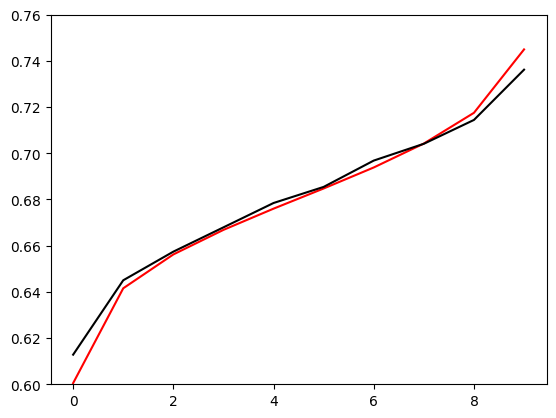

In [47]:
park = 8

venue = active_parks[park]
print(team_map.query(f'VENUE_ID == {venue}')['BBREFTEAM'])

testing_dataset['decile'] = pd.qcut(testing_dataset['is_out_pred'], 10, labels=False)

globals()["is_out_df"] = testing_dataset.groupby('decile')[['is_out_pred', 'is_out']].mean().reset_index()
# globals()["is_out_df"] = testing_dataset[testing_dataset['year'].astype(int) >= 2022].groupby('decile')[['is_out_pred', 'is_out']].mean().reset_index()
# globals()["is_out_df"] = testing_dataset.query(f'venue_id == "{active_parks[park]}"').groupby('decile')[['is_out_pred', 'is_out']].mean().reset_index()

# Post Processing:
# Create dataframe to adjust predictions to better fit test data
out_df = testing_dataset.groupby('decile').agg({'is_out_pred': ['max', 'mean'], 'is_out': 'mean'})
out_df.columns = ['is_out_pred_max', 'is_out_pred_mean', 'is_out_mean']

out_df.to_pickle(os.path.join(model_path, 'out_df.pkl'))

plt.ylim(0.6, 0.76)

# Create figures
plt.plot(is_out_df['decile'], is_out_df['is_out_pred'], color='red')
plt.plot(is_out_df['decile'], is_out_df['is_out'], color='black')
plt.show() 

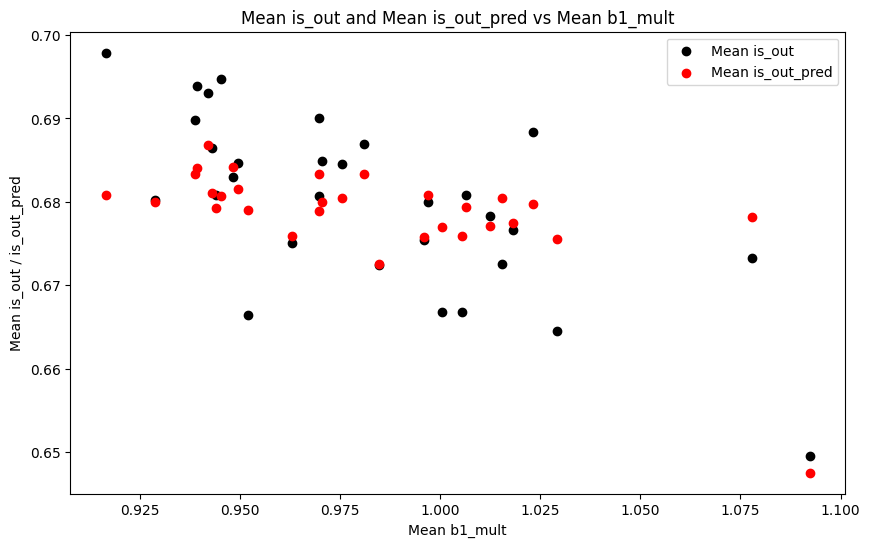

In [45]:
var = 'b1_mult'

# Assuming X_test is your DataFrame
# Group by 'venue_id' and calculate the mean for the specified columns
grouped_df = testing_dataset.groupby('venue_id')[['is_out_pred', 'is_out', f'{var}']].mean()

# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot for mean is_out
plt.scatter(grouped_df[f'{var}'], grouped_df['is_out'], color='black', label='Mean is_out')

# Scatter plot for mean is_out_pred
plt.scatter(grouped_df[f'{var}'], grouped_df['is_out_pred'], color='red', label='Mean is_out_pred')

plt.xlabel(f'Mean {var}')
plt.ylabel('Mean is_out / is_out_pred')
plt.title(f'Mean is_out and Mean is_out_pred vs Mean {var}')
plt.legend()
plt.show()


In [36]:
testing_dataset[testing_dataset['year'].astype(int) >= 2022].groupby('top')[['is_out', 'is_out_pred']].mean()

,is_out,is_out_pred
top,,
0,0.682159,0.681565
1,0.692684,0.691971


In [37]:
testing_dataset[testing_dataset['year'].astype(int) >= 2022].query('starter == 1').groupby('times_faced')[['is_out', 'is_out_pred']].mean()

,is_out,is_out_pred
times_faced,,
1,0.693461,0.691375
2,0.685642,0.686646
3,0.675375,0.680218
4,0.708984,0.683520


In [38]:
testing_dataset[testing_dataset['year'].astype(int) >= 2022].groupby('imp_p')[['is_out', 'is_out_pred']].mean()

,is_out,is_out_pred
imp_p,,
0,0.688529,0.687876
1,0.667604,0.666933


In [39]:
testing_dataset[testing_dataset['year'].astype(int) >= 2022].groupby('winning')[['is_out', 'is_out_pred']].mean()

,is_out,is_out_pred
winning,,
0,0.692486,0.692625
1,0.678839,0.676790


In [40]:
asdfdf

NameError: name 'asdfdf' is not defined

### Outs

In [ ]:
%%time
# Neural network layerss
layers = (133,66)
# To string
layers_str = ''.join(str(x) for x in layers)
# Activation method
activation = 'relu'
# Iterations
iters = 10

outs_filename = f"model_outs_{activation}_{layers_str}_{iters}_{todaysdate}.sav"
print(outs_filename)

# Define the individual models in the ensemble
models = [
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=1, early_stopping=True, learning_rate_init=0.0001, alpha=0.00001, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=2, early_stopping=True, learning_rate_init=0.0001, alpha=0.00001, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=3, early_stopping=True, learning_rate_init=0.0001, alpha=0.00001, max_iter=iters),

]

# Create the ensemble classifier using VotingClassifier
model_outs = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(outs_training_dataset[pa_inputs2], outs_training_dataset[['eventsModel']].values.ravel())

# Save model
pickle.dump(model_outs, open(os.path.join(model_path, outs_filename), 'wb'))

In [ ]:
# Predict out types
outs_outputs = list(model_outs.classes_)
outs_outputs_pred = [x + "_pred" for x in outs_outputs]

proba = model_outs.predict_proba(outs_testing_dataset[pa_inputs2])
for i, col in enumerate(outs_outputs_pred):
    outs_testing_dataset[f'{col}'] = proba[:, i]

In [ ]:
# Create deciles
for var in outs_outputs:
    outs_testing_dataset[f'{var}_act'] = (outs_testing_dataset['eventsModel'] == var).astype('int')
    outs_testing_dataset[f'{var}_decile'] = pd.qcut(outs_testing_dataset[f'{var}_pred'], 10, labels=False)
    df_name = var + "_df"
    globals()[df_name] = outs_testing_dataset.groupby([f'{var}_decile'])[[f'{var}_act', f'{var}_pred']].mean().reset_index()    
    globals()[df_name] = outs_testing_dataset[outs_testing_dataset['year'].astype(int) >= 2022].groupby([f'{var}_decile'])[[f'{var}_act', f'{var}_pred']].mean().reset_index()   
    # globals()[df_name] = outs_testing_dataset[outs_testing_dataset['venue_id'] == "3"].groupby([f'{var}_decile'])[[f'{var}_act', f'{var}_pred']].mean().reset_index()

In [ ]:
# Create figures
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, var in enumerate(outs_outputs):
    row = i // 3  # Calculate the row index based on the iteration
    col = i % 3   # Calculate the column index based on the iteration
    axs[row, col].plot(globals()[f"{var}_df"][f'{var}_decile'], globals()[f"{var}_df"][f'{var}_pred'], color='red')
    axs[row, col].plot(globals()[f"{var}_df"][f'{var}_decile'], globals()[f"{var}_df"][f'{var}_act'], color='black')
    axs[row, col].set_title(var)
    # axs[row, col].set_ylim(0,0.35)


# Add some space between subplots to prevent overlapping
fig.tight_layout(pad=.0)

# Show the figure
plt.show()

### Safe

In [ ]:
%%time
# Neural network layers
layers = (133,133,)
layers = (133,66,33,16)
# To string
layers_str = ''.join(str(x) for x in layers)
# Activation method
activation = 'relu'
# Iterations
iters = 10
# Alpha
alpha = 0.0001
# Learning Rate
learning_rate = 0.001
# Batch Size
batch_size='auto'
# batch_size=25
# Random state
random_state = 1

safe_filename = f"model_safe_{activation}_{layers_str}_{iters}_{todaysdate}.sav"
print(safe_filename)

# Define the individual models in the ensemble
models = [
    MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=True, alpha=alpha, learning_rate_init=learning_rate, early_stopping=True, random_state=random_state+i, max_iter=iters, batch_size=batch_size)
    for i in range(5)
]

# Create the ensemble classifier using VotingClassifier
model_safe = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(safe_training_dataset[pa_inputs2], safe_training_dataset[['eventsModel']].values.ravel())

# Save model
pickle.dump(model_safe, open(os.path.join(model_path, safe_filename), 'wb'))

In [ ]:
# Predict safe types
safe_outputs = list(model_safe.classes_)
safe_outputs_pred = [x + "_pred" for x in safe_outputs]

proba = model_safe.predict_proba(safe_testing_dataset[pa_inputs2])
for i, col in enumerate(safe_outputs_pred):
    safe_testing_dataset[f'{col}'] = proba[:, i]

In [ ]:
# Create deciles
for var in safe_outputs:
    safe_testing_dataset[f'{var}_act'] = (safe_testing_dataset['eventsModel'] == var).astype('int')
    safe_testing_dataset[f'{var}_decile'] = pd.qcut(safe_testing_dataset[f'{var}_pred'], 10, labels=False)
    df_name = var + "_df"
    globals()[df_name] = safe_testing_dataset.groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    globals()[df_name] = safe_testing_dataset[safe_testing_dataset['year'].astype(int) >= 2022].groupby([f'{var}_decile'])[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    # globals()[df_name] = safe_testing_dataset[safe_testing_dataset['venue_id'] == "19"].groupby([f'{var}_decile'])[[f'{var}_act', f'{var}_pred']].mean().reset_index()


In [ ]:
# Create figures
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, var in enumerate(safe_outputs):
    row = i // 3  # Calculate the row index based on the iteration
    col = i % 3   # Calculate the column index based on the iteration
    axs[row, col].plot(globals()[f"{var}_df"][f'{var}_decile'], globals()[f"{var}_df"][f'{var}_act'], color='black')
    axs[row, col].plot(globals()[f"{var}_df"][f'{var}_decile'], globals()[f"{var}_df"][f'{var}_pred'], color='red')
    axs[row, col].set_title(var)
    # axs[row, col].set_ylim(globals()[df_name][f'{var}_act'].min(),globals()[df_name][f'{var}_act'].max())
    

# Add some space between subplots to prevent overlapping
fig.tight_layout(pad=.0)

# Show the figure
plt.show()

In [ ]:
# 20

In [ ]:
# Create figures
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, var in enumerate(safe_outputs):
    row = i // 3  # Calculate the row index based on the iteration
    col = i % 3   # Calculate the column index based on the iteration
    axs[row, col].plot(globals()[f"{var}_df"][f'{var}_decile'], globals()[f"{var}_df"][f'{var}_act'], color='black')
    axs[row, col].plot(globals()[f"{var}_df"][f'{var}_decile'], globals()[f"{var}_df"][f'{var}_pred'], color='red')
    axs[row, col].set_title(var)
    # axs[row, col].set_ylim(globals()[df_name][f'{var}_act'].min(),globals()[df_name][f'{var}_act'].max())
    

# Add some space between subplots to prevent overlapping
fig.tight_layout(pad=.0)

# Show the figure
plt.show()

In [ ]:
safe_testing_dataset.groupby('top')[['hr_act', 'hr_pred']].mean()

In [ ]:
safe_testing_dataset.head()

In [ ]:
nnnnnn

In [ ]:
import os
import pickle
import itertools
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# Define possible layer configurations
layer_configs = [(133, 133), (133, 66)]

# Other parameters
activation = 'relu'
iters = 10
alpha = 0.0001
learning_rate = 0.001
batch_size = 'auto'
random_state = 1000

best_accuracy = 0
best_config = None

for layers in layer_configs:
    layers_str = ''.join(str(x) for x in layers)
    safe_filename = f"model_safe_{activation}_{layers_str}_{iters}_{todaysdate}.sav"
    
    # Define the individual models in the ensemble
    models = [
        MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=True, alpha=alpha, learning_rate_init=learning_rate, early_stopping=True, random_state=random_state+i, max_iter=iters, batch_size=batch_size)
        for i in range(5)
    ]
    
    # Create the ensemble classifier using VotingClassifier
    model_safe = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2)
    
    # Fit the model
    model_safe.fit(safe_training_dataset[pa_inputs2], safe_training_dataset[['eventsModel']].values.ravel())
    
    # Predict on the training set (or use a validation set if available)
    predictions = model_safe.predict(safe_training_dataset[pa_inputs2])
    
    # Calculate accuracy
    accuracy = accuracy_score(safe_training_dataset[['eventsModel']].values.ravel(), predictions)
    print(f"Layers: {layers}, Accuracy: {accuracy}")
    
    # Save the model if it's the best so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_config = layers
        pickle.dump(model_safe, open(os.path.join(model_path, safe_filename), 'wb'))

print(f"Best Configuration: {best_config}, Accuracy: {best_accuracy}")


In [ ]:
import os
import pickle
import itertools
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Define possible configurations
layer_configs = [(133, 133), (133, 66)]
iterations = [10,]
alphas = [0.001,]
learning_rates = [0.001,]
batch_sizes = ['auto', 10]
activations = ['relu',]

# Other parameters
random_state = 1000

best_f1_score = 0
best_config = None

for layers, iters, alpha, learning_rate, batch_size, activation in itertools.product(
        layer_configs, iterations, alphas, learning_rates, batch_sizes, activations):
    layers_str = ''.join(str(x) for x in layers)
    safe_filename = f"model_safe_{activation}_{layers_str}_{iters}_{alpha}_{learning_rate}_{batch_size}_{todaysdate}.sav"
    
    # Define the individual models in the ensemble
    models = [
        MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=True, alpha=alpha, learning_rate_init=learning_rate, early_stopping=True, random_state=random_state+i, max_iter=iters, batch_size=batch_size)
        for i in range(5)
    ]
    
    # Create the ensemble classifier using VotingClassifier
    model_safe = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2)
    
    # Fit the model
    model_safe.fit(safe_training_dataset[pa_inputs2], safe_training_dataset[['eventsModel']].values.ravel())
    
    # Predict on the training set (or use a validation set if available)
    predictions = model_safe.predict(safe_training_dataset[pa_inputs2])
    y_true = safe_training_dataset[['eventsModel']].values.ravel()
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, predictions)
    precision = precision_score(y_true, predictions, average='weighted')
    recall = recall_score(y_true, predictions, average='weighted')
    f1 = f1_score(y_true, predictions, average='weighted')
    roc_auc = roc_auc_score(y_true, model_safe.predict_proba(c[pa_inputs2]), multi_class='ovr')
    
    print(f"Layers: {layers}, Iters: {iters}, Alpha: {alpha}, Learning Rate: {learning_rate}, Batch Size: {batch_size}, Activation: {activation}")
    print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}, ROC-AUC: {roc_auc}")
    
    # Save the model if it's the best so far based on F1 Score
    if f1 > best_f1_score:
        best_f1_score = f1
        best_config = (layers, iters, alpha, learning_rate, batch_size, activation)
        pickle.dump(model_safe, open(os.path.join(model_path, safe_filename), 'wb'))

print(f"Best Configuration: {best_config}, Best F1 Score: {best_f1_score}")


In [ ]:
safe_training_dataset.tail()